### Time Series Workshop 
# 3. Air Pollutants &#x1F525;: Forecasting

In this notebook, we will use the preprocessed data from the feature engineering notebook and, finally, perform some forecasting!

In [41]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from timeseries.utils import print_metrics

DATA_DIR = Path("..") / Path("data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [21]:
FILE_PATH = DATA_DIR / "air_quality_processed.csv"

df_in = pd.read_csv(
    FILE_PATH,
    parse_dates=["date_time"],
    index_col=["date_time"],
)
df_in.head(2)


,co_sensor,month,week,day,day_of_week,hour,is_weekend,co_sensor_lag_1,co_sensor_lag_2,co_sensor_lag_3,...,co_sensor_win_max,co_sensor_win_std,humidity_win_mean,humidity_win_min,humidity_win_max,humidity_win_std,month_sin,month_cos,hour_sin,hour_cos
date_time,,,,,,,,,,,,,,,,,,,,,
2004-04-05 00:00:00,1065.0,4,15,5,0,0,0,1188.0,1196.0,1113.0,...,1420.0,130.064599,53.84,44.6,60.8,6.854415,0.866025,-0.5,0.000000,1.000000
2004-04-05 01:00:00,999.0,4,15,5,0,1,0,1065.0,1188.0,1196.0,...,1366.0,114.535147,58.08,48.9,65.8,6.239151,0.866025,-0.5,0.269797,0.962917


# Train-test split

* We will train the model on a certain portion of the data and leave another part out to evaluate the model.

* Contrary to regular machine learning problems, it is neccessary to strictly split on time in order to avoid leakage. 

* We will roughly use the first 90% of the data for training and the remaining 10% for testing.

In [22]:
SPLIT_DATE = "2005-02-01"
TARGET_COL = "co_sensor"

X_train = df_in[df_in.index <= SPLIT_DATE]
X_test = df_in[df_in.index > SPLIT_DATE]

y_train = X_train.pop(TARGET_COL)
y_test = X_test.pop(TARGET_COL)

train_ratio = len(y_train) / len(df_in)
test_ratio = len(y_test) / len(df_in)

print(f"Train vs. test ratios: {train_ratio:.2%} vs. {test_ratio:.2%}")


Train vs. test ratios: 86.02% vs. 13.98%


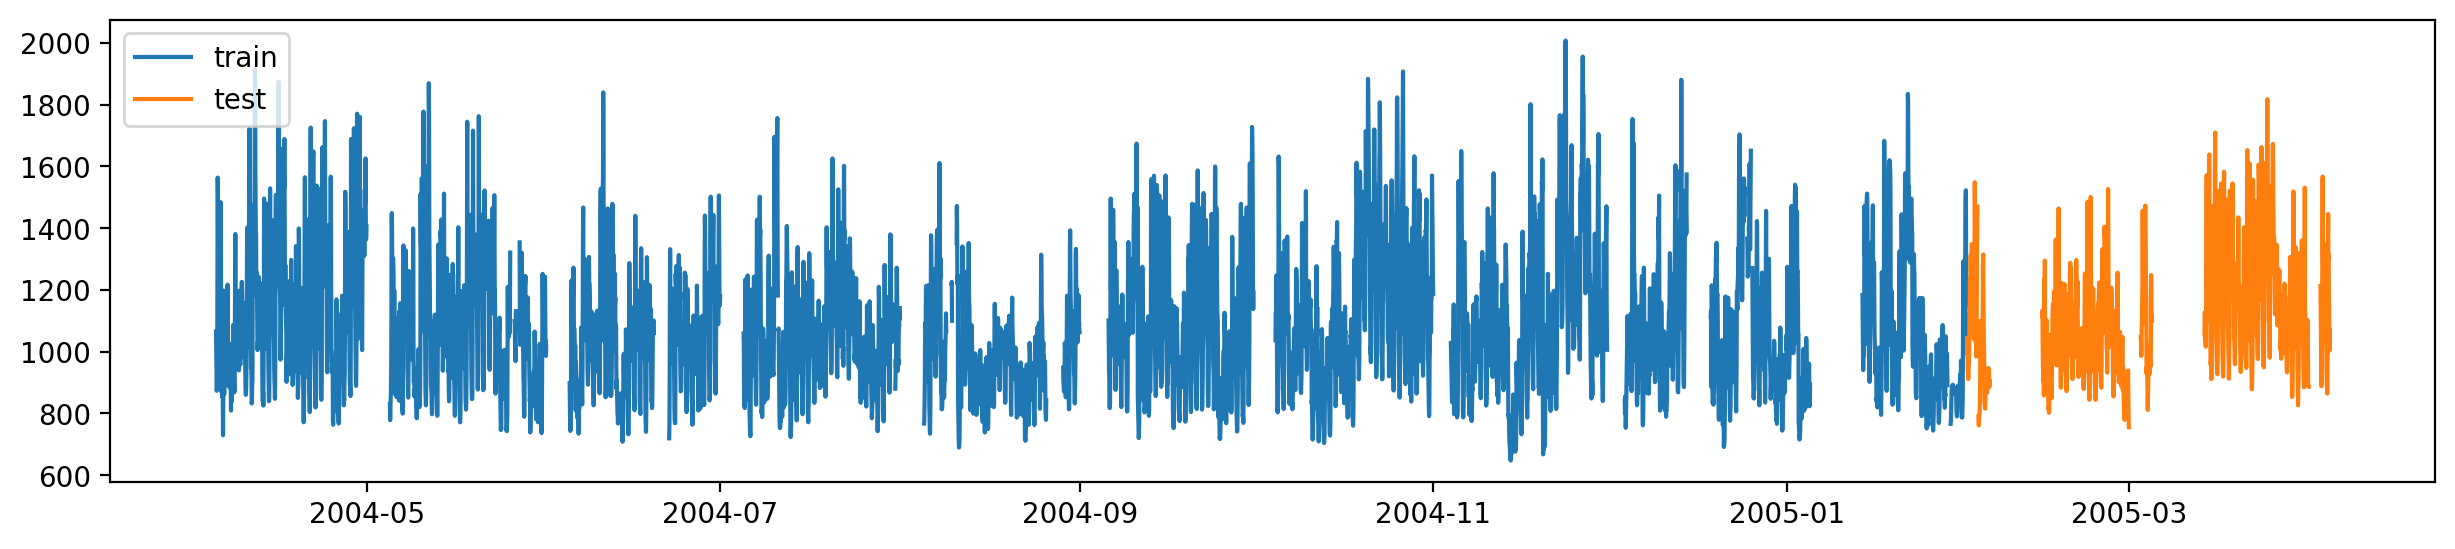

In [57]:
train_range = pd.DataFrame(
    index=pd.date_range(y_train.index.min(), y_train.index.max(), freq="1H")
)
test_range = pd.DataFrame(
    index=pd.date_range(y_test.index.min(), y_test.index.max(), freq="1H")
)

y_train_plt = train_range.merge(y_train, left_index=True, right_index=True, how="left")
y_test_plt = test_range.merge(y_test, left_index=True, right_index=True, how="left")

_, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(y_train_plt, label="train")
_ = ax.plot(y_test_plt, label="test")
_ = plt.legend(loc="upper left")

# Random Forest Regressor

In [69]:
RF_FEATURES = [
    "month",
    "week",
    "day",
    "day_of_week",
    "hour",
    "is_weekend",
    "co_sensor_lag_1",
    "co_sensor_lag_2",
    "co_sensor_lag_3",
    "co_sensor_lag_24",
    "humidity_lag_1",
    "humidity_lag_2",
    "humidity_lag_3",
    "humidity_lag_24",
    "co_sensor_win_mean",
    "co_sensor_win_min",
    "co_sensor_win_max",
    "co_sensor_win_std",
    "humidity_win_mean",
    "humidity_win_min",
    "humidity_win_max",
    "humidity_win_std",
]

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=4,
    random_state=0,
)
rf_model.fit(X_train[RF_FEATURES], y_train)

y_pred = rf_model.predict(X_test[RF_FEATURES])
print_metrics(y_test, y_pred)

RMSE:      94.14
MAE:       65.97
MAPE:       5.68%


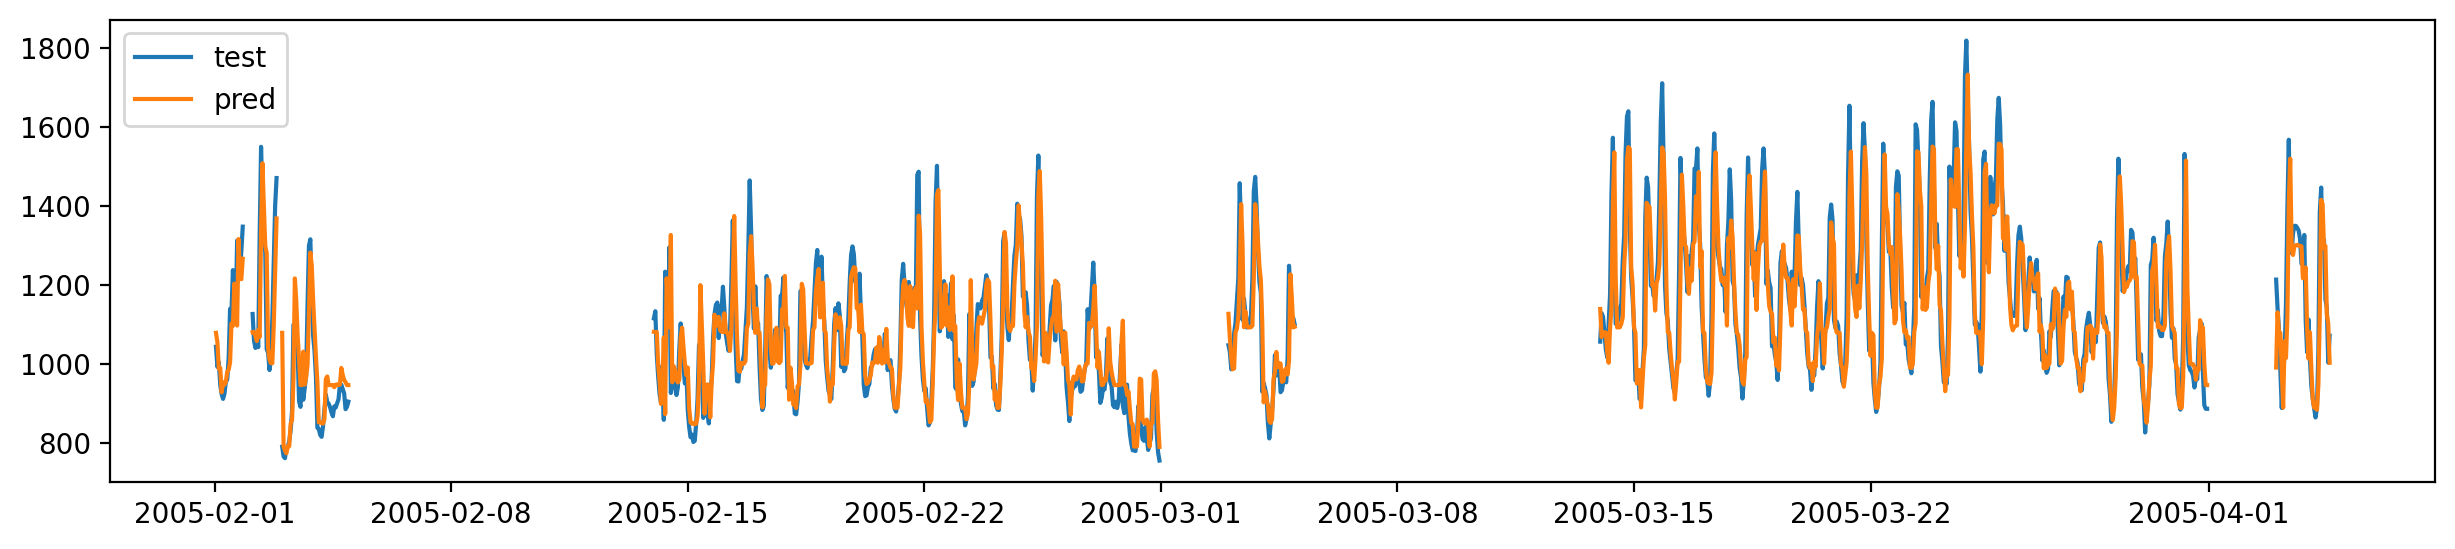

In [71]:
y_pred_plt = test_range.merge(
    pd.Series(y_pred, index=y_test.index, name="pred"),
    left_index=True,
    right_index=True,
    how="left",
)

_, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(y_test_plt, label="test")
_ = ax.plot(y_pred_plt, label="pred")
_ = plt.legend(loc="upper left")

# Linear Regression

In [79]:
LINEAR_FEATURES = [
    "is_weekend",
    "co_sensor_lag_1",
    "co_sensor_lag_2",
    "co_sensor_lag_3",
    "co_sensor_lag_24",
    "humidity_lag_1",
    "humidity_lag_2",
    "humidity_lag_3",
    "humidity_lag_24",
    "co_sensor_win_mean",
    "co_sensor_win_min",
    "co_sensor_win_max",
    "co_sensor_win_std",
    "humidity_win_mean",
    "humidity_win_min",
    "humidity_win_max",
    "humidity_win_std",
    "month_sin",
    "month_cos",
    "hour_sin",
    "hour_cos",
]

linear_model = Lasso(alpha=100, random_state=0)
linear_model.fit(X_train[LINEAR_FEATURES], y_train)

y_pred = linear_model.predict(X_test[LINEAR_FEATURES])
print_metrics(y_test, y_pred)

RMSE:      86.90
MAE:       61.22
MAPE:       5.35%


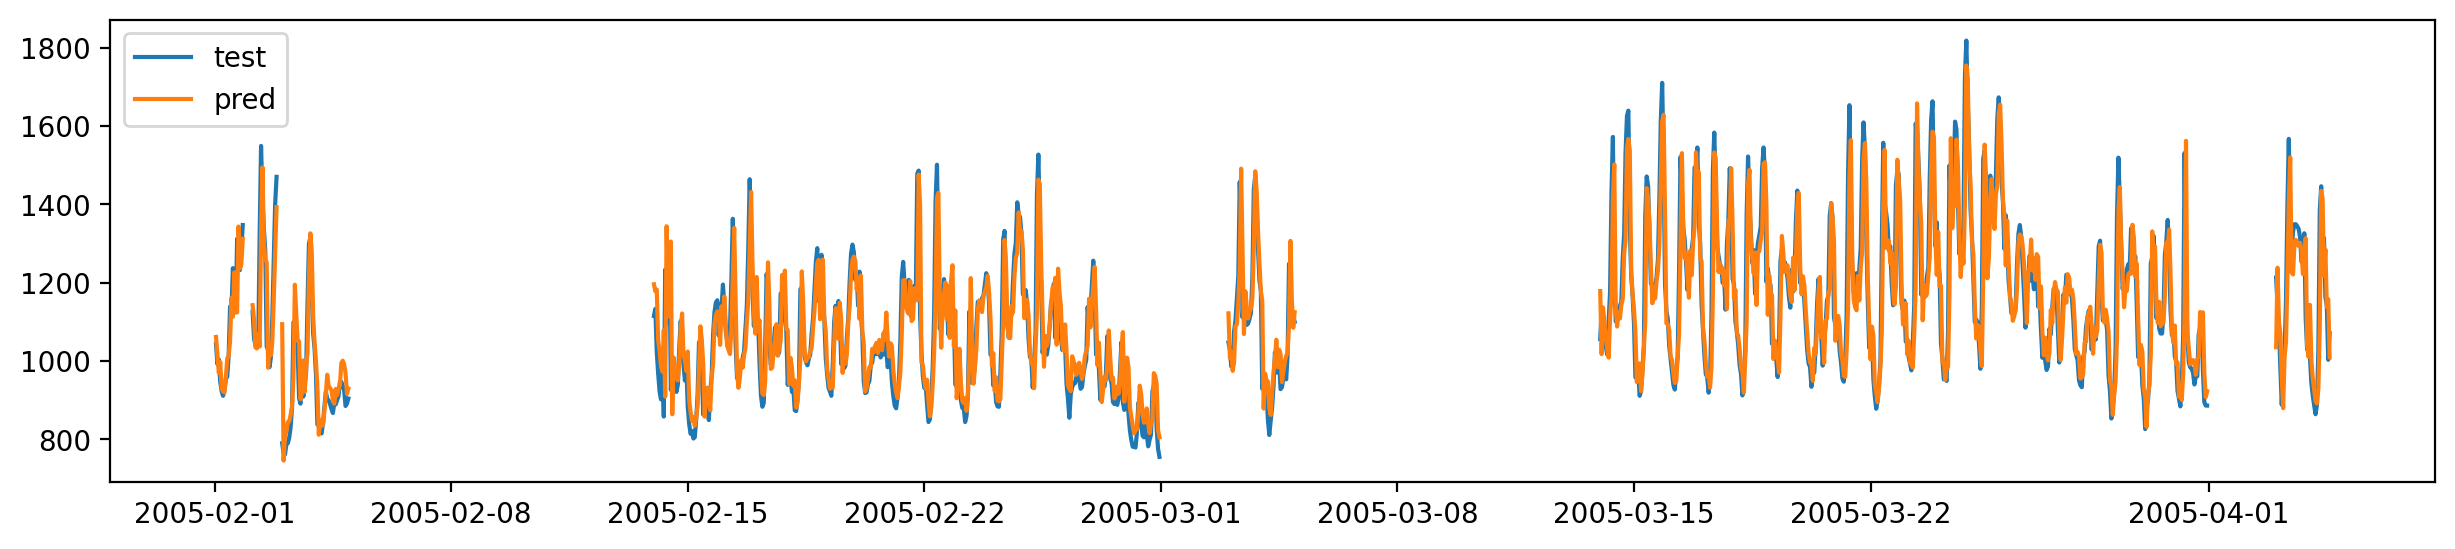

In [80]:
y_pred_plt = test_range.merge(
    pd.Series(y_pred, index=y_test.index, name="pred"),
    left_index=True,
    right_index=True,
    how="left",
)

_, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(y_test_plt, label="test")
_ = ax.plot(y_pred_plt, label="pred")
_ = plt.legend(loc="upper left")

Now this looks pretty amazing. But what should we have done first?

## Did we forget something? &#x1F6A8;
